# Fine-Tune CNN

## Load libraries

In [1]:
import os # store and load weight
import pandas as pd # load data
import nltk # text processing
from nltk.stem import PorterStemmer # text processing
from nltk.corpus import stopwords #text processing
import numpy as np # one-hot vector
import matplotlib.pyplot as plt # model analysis
from itertools import chain # feature construction
from collections import Counter # build feats-dict
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

## Utils

In [2]:
def load_data(filename):
    """
    Input: string filename
    Output: a pandas dataframe for the whole dataset after droping missing values
    Support google colab or local environments
    """
    try:
        # local environment
        df = pd.read_csv(filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df
    except:
        # google colab environment
        from google.colab import drive
        drive.mount('/content/drive')
        
        df = pd.read_csv('/content/drive/MyDrive/' + filename)
        df = df.dropna(subset=['sentence', 'label']) ## drop missing values
        return df

In [3]:
def split_data(df):
    """
    Input: pandas dataframe
    Output: training dataframe (81%), validation dataframe (9%), test dataframe (10%)
    """
    df_train, df_val = train_test_split(df, stratify=df['label'],test_size=0.1, random_state=42)
    
    return df_train, df_val

In [4]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

# Get index vector
def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        try:
            vector[i] = feats_dict[f]
        except KeyError:
            vector[i] = 1
    return vector

In [5]:
def build_CNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              kernel_sizes, num_filters, num_mlp_layers,
              padding="valid",
              strides=1,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1):

    x = Input(shape=(input_length,))
    
    #### word representation layer ####
    emb = Embedding(input_dim=vocab_size, output_dim=embedding_size)(x)
    
    #### convolutional and pooling layers ####
    cnn_results = list()
    for kernel_size in kernel_sizes:
        # add convolutional layer
        conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, strides=strides)(emb)
        # add batch normalization layer
        if batch_norm:
            conv = BatchNormalization()(conv)
        # add activation
        conv = Activation(activation)(conv)
        # add max-pooling
        maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)
        cnn_results.append(Flatten()(maxpool))
    
    ##### Fully Connected Layer ####
    h = Concatenate()(cnn_results) if len(kernel_sizes) > 1 else cnn_results[0]
    h = Dropout(dropout_rate, seed=0)(h)
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

## Load data

In [6]:
FILENAME = 'final_dataset_formatted.csv'
TEST_FILENAME = 'final_dataset_formatted_test.csv'

# load data
df = load_data(FILENAME)
df_test = load_data(TEST_FILENAME)

# labels
labels = ['CC', 'NC', 'PW', 'HC', 'PL', 'CR', 'CG', 'BE', 'N']
num_labels = 9

# split data
df_train, df_val = split_data(df)

## Preprocess data

In [7]:
# split text and labels
train_texts = df_train.iloc[:, 0]
train_labels = df_train.iloc[:, 1]
valid_texts = df_val.iloc[:, 0]
valid_labels = df_val.iloc[:, 1]
test_texts = df_test.iloc[:, 0]
test_labels = df_test.iloc[:, 1]

In [8]:
# get train, validation, and test dataset size
train_size = len(train_texts)
valid_size = len(valid_texts)
test_size = len(test_texts)

print(f'train size: {train_size}')
print(f'valid size: {valid_size}')
print(f'test size: {test_size}')

train size: 3645
valid size: 405
test size: 450


In [9]:
# extract features
min_freq = 3

train_tokens = [tokenize(text) for text in train_texts]
valid_tokens = [tokenize(text) for text in valid_texts]
test_tokens = [tokenize(text) for text in test_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]
test_stemmed = [stem(tokens) for tokens in test_tokens]

train_feats = [filter_stopwords(tokens) for tokens in train_stemmed]
valid_feats = [filter_stopwords(tokens) for tokens in valid_stemmed]
test_feats = [filter_stopwords(tokens) for tokens in test_stemmed]

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)

Size of features: 2465


In [10]:
max_len = 75 # from EDA

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_feats])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_feats])

# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels, num_classes=num_labels)
valid_label_matrix = keras.utils.to_categorical(valid_labels, num_classes=num_labels)
test_label_matrix = tf.keras.utils.to_categorical(test_labels, num_classes=num_labels)

## Fine-Tune Model  
  
optimizer  
embedding_size    
hidden_size  
kernel_sizes   
num_filters  
num_mlp_layers  
strides  
dropout_rate  
l2_reg  
batch_norm  
learning_rate  

In [11]:
# set seed
np.random.seed(0)
tf.random.set_seed(0)

In [12]:
# indicator for saving models' weights
count = 0

# initial settings
epoch = 20
batch_size = 100
optimizer = 'SGD'
embedding_size = 100
hidden_size = 100
kernel_sizes = [1, 2, 3, 4]
num_filters = 100
num_mlp_layers = 3
strides = 1
dropout_rate = 0.5
l2_reg = 0.005
batch_norm = True
learning_rate = 0.1

### optimizer

In [13]:
optimizer_list = ['SGD', 'RMSprop', 'Adam']
best_optimizer = ''
best_acc = 0
best_f1 = 0

for optimizer in optimizer_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'optimizer: {optimizer}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_optimizer = optimizer
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'optimizer: {best_optimizer}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 1
optimizer: SGD
13/13 [==============================] - 1s 19ms/step
accuracy: 0.8296
macro_f1: 0.8308
----------------------------------------------------------------------------
count: 2
optimizer: RMSprop
13/13 [==============================] - 8s 19ms/step
accuracy: 0.8148
macro_f1: 0.8159
----------------------------------------------------------------------------
count: 3
optimizer: Adam
13/13 [==============================] - 17s 29ms/step
accuracy: 0.8198
macro_f1: 0.8197
----------------------------------------------------------------------------
Best model:
optimizer: SGD, accuracy: 0.8296296296296296, macro_f1: 0.8307689237655485


In [14]:
optimizer = best_optimizer

### embedding_size

In [15]:
embedding_size_list = [50, 75, 100, 128, 256]
best_embedding_size = 0
best_acc = 0
best_f1 = 0

for embedding_size in embedding_size_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'embedding_size: {embedding_size}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_embedding_size = embedding_size
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'embedding_size: {best_embedding_size}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 4
embedding_size: 50
13/13 [==============================] - 7s 17ms/step
accuracy: 0.8049
macro_f1: 0.8065
----------------------------------------------------------------------------
count: 5
embedding_size: 75
13/13 [==============================] - 16s 22ms/step
accuracy: 0.8074
macro_f1: 0.8086
----------------------------------------------------------------------------
count: 6
embedding_size: 100
13/13 [==============================] - 13s 22ms/step
accuracy: 0.8321
macro_f1: 0.8338
----------------------------------------------------------------------------
count: 7
embedding_size: 128
13/13 [==============================] - 13s 34ms/step
accuracy: 0.8123
macro_f1: 0.8155
----------------------------------------------------------------------------
count: 8
embedding_size: 256
13/13 [==============================] - 14s 51ms/step
accuracy: 0.8173
macro_f1: 0.8176
----------------------------------------------------------------------------
Best model:
embedding_size: 

In [16]:
embedding_size = best_embedding_size

### hidden_size

In [17]:
hidden_size_list = [50, 75, 100, 128, 256]
best_hidden_size = 0
best_acc = 0
best_f1 = 0

for hidden_size in hidden_size_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'hidden_size: {hidden_size}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_hidden_size = hidden_size
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'hidden_size: {best_hidden_size}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 9
hidden_size: 50
13/13 [==============================] - 8s 23ms/step
accuracy: 0.8025
macro_f1: 0.8052
----------------------------------------------------------------------------
count: 10
hidden_size: 75
13/13 [==============================] - 4s 24ms/step
accuracy: 0.8296
macro_f1: 0.8313
----------------------------------------------------------------------------
count: 11
hidden_size: 100
13/13 [==============================] - 12s 25ms/step
accuracy: 0.8222
macro_f1: 0.8241
----------------------------------------------------------------------------
count: 12
hidden_size: 128
13/13 [==============================] - 2s 25ms/step
accuracy: 0.8123
macro_f1: 0.8134
----------------------------------------------------------------------------
count: 13
hidden_size: 256
13/13 [==============================] - 3s 24ms/step
accuracy: 0.7778
macro_f1: 0.7833
----------------------------------------------------------------------------
Best model:
hidden_size: 75, accuracy: 0.8

In [18]:
hidden_size = best_hidden_size

### kernel_size

In [19]:
kernel_size_list = [[1], [1, 2], [1, 2, 3], [1, 2, 3, 4]]
best_kernel_size = []
best_acc = 0
best_f1 = 0

for kernel_size in kernel_size_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'kernel_size: {kernel_size}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_kernel_size = kernel_size
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'kernel_size: {best_kernel_size}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 14
kernel_size: [1]
13/13 [==============================] - 3s 20ms/step
accuracy: 0.8247
macro_f1: 0.8251
----------------------------------------------------------------------------
count: 15
kernel_size: [1, 2]
13/13 [==============================] - 3s 24ms/step
accuracy: 0.8247
macro_f1: 0.8254
----------------------------------------------------------------------------
count: 16
kernel_size: [1, 2, 3]
13/13 [==============================] - 2s 22ms/step
accuracy: 0.8198
macro_f1: 0.8219
----------------------------------------------------------------------------
count: 17
kernel_size: [1, 2, 3, 4]
13/13 [==============================] - 4s 20ms/step
accuracy: 0.8272
macro_f1: 0.8277
----------------------------------------------------------------------------
Best model:
kernel_size: [1, 2, 3, 4], accuracy: 0.8271604938271605, macro_f1: 0.827652249795631


In [20]:
kernel_size = best_kernel_size

### num_filters

In [21]:
num_filters_list = [25, 50, 100, 150, 200, 256]
best_num_filters = 0
best_acc = 0
best_f1 = 0

for num_filters in num_filters_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'num_filters: {num_filters}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_num_filters = num_filters
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'num_filters: {best_num_filters}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 18
num_filters: 25
13/13 [==============================] - 8s 20ms/step
accuracy: 0.7580
macro_f1: 0.7616
----------------------------------------------------------------------------
count: 19
num_filters: 50
13/13 [==============================] - 3s 7ms/step
accuracy: 0.8148
macro_f1: 0.8155
----------------------------------------------------------------------------
count: 20
num_filters: 100
13/13 [==============================] - 1s 7ms/step
accuracy: 0.8222
macro_f1: 0.8245
----------------------------------------------------------------------------
count: 21
num_filters: 150
13/13 [==============================] - 1s 16ms/step
accuracy: 0.8148
macro_f1: 0.8161
----------------------------------------------------------------------------
count: 22
num_filters: 200
13/13 [==============================] - 1s 14ms/step
accuracy: 0.8222
macro_f1: 0.8221
----------------------------------------------------------------------------
count: 23
num_filters: 256
13/13 [==========

In [22]:
num_filters = best_num_filters

### num_mlp_layers

In [23]:
num_mlp_layers_list = [1, 2, 3, 4, 5]
best_num_mlp_layers = 0
best_acc = 0
best_f1 = 0

for num_mlp_layers in num_mlp_layers_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'num_mlp_layers: {num_mlp_layers}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_num_mlp_layers = num_mlp_layers
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'num_mlp_layers: {best_num_mlp_layers}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 24
num_mlp_layers: 1
13/13 [==============================] - 1s 34ms/step
accuracy: 0.7901
macro_f1: 0.7879
----------------------------------------------------------------------------
count: 25
num_mlp_layers: 2
13/13 [==============================] - 1s 21ms/step
accuracy: 0.8469
macro_f1: 0.8470
----------------------------------------------------------------------------
count: 26
num_mlp_layers: 3
13/13 [==============================] - 1s 20ms/step
accuracy: 0.8222
macro_f1: 0.8234
----------------------------------------------------------------------------
count: 27
num_mlp_layers: 4
13/13 [==============================] - 1s 28ms/step
accuracy: 0.8247
macro_f1: 0.8246
----------------------------------------------------------------------------
count: 28
num_mlp_layers: 5
13/13 [==============================] - 2s 27ms/step
accuracy: 0.8296
macro_f1: 0.8309
----------------------------------------------------------------------------
Best model:
num_mlp_layers: 2, accu

In [24]:
num_mlp_layers = best_num_mlp_layers

### strides

In [25]:
strides_list = [1, 2, 3]
best_strides = ''
best_acc = 0
best_f1 = 0

for strides in strides_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'strides: {strides}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_strides = strides
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'strides: {best_strides}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 29
strides: 1
13/13 [==============================] - 1s 16ms/step
accuracy: 0.8296
macro_f1: 0.8310
----------------------------------------------------------------------------
count: 30
strides: 2
13/13 [==============================] - 2s 34ms/step
accuracy: 0.8247
macro_f1: 0.8246
----------------------------------------------------------------------------
count: 31
strides: 3
13/13 [==============================] - 1s 20ms/step
accuracy: 0.8025
macro_f1: 0.8038
----------------------------------------------------------------------------
Best model:
strides: 1, accuracy: 0.8296296296296296, macro_f1: 0.830995387119247


In [26]:
strides = best_strides

### dropout_rate

In [27]:
dropout_rate_list = [0.1, 0.3, 0.5, 0.6, 0.7]
best_dropout_rate = 0
best_acc = 0
best_f1 = 0

for dropout_rate in dropout_rate_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'dropout_rate: {dropout_rate}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_dropout_rate = dropout_rate
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'dropout_rate: {best_dropout_rate}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 32
dropout_rate: 0.1
13/13 [==============================] - 1s 29ms/step
accuracy: 0.8346
macro_f1: 0.8354
----------------------------------------------------------------------------
count: 33
dropout_rate: 0.3
13/13 [==============================] - 1s 38ms/step
accuracy: 0.8198
macro_f1: 0.8197
----------------------------------------------------------------------------
count: 34
dropout_rate: 0.5
13/13 [==============================] - 4s 61ms/step
accuracy: 0.8247
macro_f1: 0.8260
----------------------------------------------------------------------------
count: 35
dropout_rate: 0.6
13/13 [==============================] - 2s 41ms/step
accuracy: 0.8370
macro_f1: 0.8395
----------------------------------------------------------------------------
count: 36
dropout_rate: 0.7
13/13 [==============================] - 3s 41ms/step
accuracy: 0.8420
macro_f1: 0.8424
----------------------------------------------------------------------------
Best model:
dropout_rate: 0.7, accu

In [28]:
dropout_rate = best_dropout_rate

### l2_reg

In [29]:
l2_reg_list = [0.001, 0.005, 0.01, 0.1]
best_l2_reg = 0
best_acc = 0
best_f1 = 0

for l2_reg in l2_reg_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'l2_reg: {l2_reg}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_l2_reg = l2_reg
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'l2_reg: {best_l2_reg}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 37
l2_reg: 0.001
13/13 [==============================] - 5s 53ms/step
accuracy: 0.8296
macro_f1: 0.8300
----------------------------------------------------------------------------
count: 38
l2_reg: 0.005
13/13 [==============================] - 2s 22ms/step
accuracy: 0.8346
macro_f1: 0.8347
----------------------------------------------------------------------------
count: 39
l2_reg: 0.01
13/13 [==============================] - 2s 34ms/step
accuracy: 0.8296
macro_f1: 0.8303
----------------------------------------------------------------------------
count: 40
l2_reg: 0.1
13/13 [==============================] - 1s 32ms/step
accuracy: 0.8395
macro_f1: 0.8390
----------------------------------------------------------------------------
Best model:
l2_reg: 0.1, accuracy: 0.8395061728395061, macro_f1: 0.8390493350258094


In [30]:
l2_reg = best_l2_reg

### batch_norm

In [31]:
batch_norm_list = [True, False]
best_batch_norm = False
best_acc = 0
best_f1 = 0

for batch_norm in batch_norm_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'batch_norm: {batch_norm}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_batch_norm = batch_norm
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'batch_norm: {best_batch_norm}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 41
batch_norm: True
13/13 [==============================] - 1s 26ms/step
accuracy: 0.8123
macro_f1: 0.8123
----------------------------------------------------------------------------
count: 42
batch_norm: False
13/13 [==============================] - 1s 18ms/step
accuracy: 0.2272
macro_f1: 0.1484
----------------------------------------------------------------------------
Best model:
batch_norm: True, accuracy: 0.8123456790123457, macro_f1: 0.8123124347433277


In [32]:
batch_norm = best_batch_norm

### learning_rate

In [33]:
learning_rate_list = [0.0001, 0.001, 0.01, 0.1]
best_learning_rate = 0
best_acc = 0
best_f1 = 0

for learning_rate in learning_rate_list:

    count += 1

    model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

    checkpointer = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("models", f"weights_CNN_tune{count}.hdf5"),
        monitor="val_accuracy",
        verbose=0,
        save_best_only=True)

    mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_data=(valid_feats_matrix, valid_label_matrix),
                        epochs=epoch, batch_size=batch_size, verbose=0,
                        callbacks=[checkpointer])

    model = keras.models.load_model(os.path.join("models", f"weights_CNN_tune{count}.hdf5"))

    print(f'count: {count}')
    print(f'learning_rate: {learning_rate}')

    # evaluation
    # generate prediction and format
    y_pred = model.predict(valid_feats_matrix)
    y_pred = [np.argmax(row) for row in y_pred]
    y_pred = np.array(y_pred)

    # evaluate performance
    acc = accuracy_score(valid_labels, y_pred)
    f1 = f1_score(valid_labels, y_pred, average='macro')
    print(f'accuracy: {acc:.4f}')
    print(f'macro_f1: {f1:.4f}')

    # save best model
    if f1 > best_f1:
        best_learning_rate = learning_rate
        best_acc = acc
        best_f1 = f1
    
    print('----------------------------------------------------------------------------')

print('Best model:')
print(f'learning_rate: {best_learning_rate}, accuracy: {best_acc}, macro_f1: {best_f1}')

count: 43
learning_rate: 0.0001
13/13 [==============================] - 1s 16ms/step
accuracy: 0.1235
macro_f1: 0.0761
----------------------------------------------------------------------------
count: 44
learning_rate: 0.001
13/13 [==============================] - 1s 28ms/step
accuracy: 0.1407
macro_f1: 0.0999
----------------------------------------------------------------------------
count: 45
learning_rate: 0.01
13/13 [==============================] - 1s 25ms/step
accuracy: 0.7062
macro_f1: 0.7243
----------------------------------------------------------------------------
count: 46
learning_rate: 0.1
13/13 [==============================] - 1s 23ms/step
accuracy: 0.8296
macro_f1: 0.8292
----------------------------------------------------------------------------
Best model:
learning_rate: 0.1, accuracy: 0.8296296296296296, macro_f1: 0.8292414238255478


In [34]:
learning_rate = best_learning_rate

## Final CNN Model

In [35]:
# best model obtained before
epoch = 35
batch_size = 100
optimizer = 'SGD'
embedding_size = 256
hidden_size = 100
kernel_sizes = [1, 2]
num_filters = 256
num_mlp_layers = 4
strides = 1
dropout_rate = 0.5
l2_reg = 0.005
batch_norm = True
learning_rate = 0.1

In [36]:
model = build_CNN(input_length=max_len, 
                      vocab_size=len(feats_dict), 
                      embedding_size=embedding_size, 
                      hidden_size=hidden_size,
                      output_size=num_labels,
                      kernel_sizes=kernel_sizes, 
                      num_filters=num_filters, 
                      num_mlp_layers=num_mlp_layers, 
                      strides=strides, 
                      dropout_rate=dropout_rate, 
                      batch_norm=batch_norm,
                      l2_reg=l2_reg,
                      optimizer=optimizer, 
                      learning_rate=learning_rate
                     )

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", f"weights_CNN_final.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(valid_feats_matrix, valid_label_matrix),
                    epochs=epoch, batch_size=batch_size, verbose=1,
                    callbacks=[checkpointer])

model = keras.models.load_model(os.path.join("models", f"weights_CNN_final.hdf5"))

# evaluation
# generate prediction and format
y_pred = model.predict(valid_feats_matrix)
y_pred = [np.argmax(row) for row in y_pred]
y_pred = np.array(y_pred)

# evaluate performance
acc = accuracy_score(valid_labels, y_pred)
f1 = f1_score(valid_labels, y_pred, average='macro')
print(f'accuracy: {acc:.4f}')
print(f'macro_f1: {f1:.4f}')

Epoch 1/35
37/37 [==============================] - 14s 245ms/step - loss: 5.1881 - accuracy: 0.2335 - precision_46: 0.4208 - recall_46: 0.0875 - val_loss: 4.9959 - val_accuracy: 0.1111 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00
Epoch 2/35
37/37 [==============================] - 8s 207ms/step - loss: 4.1441 - accuracy: 0.5147 - precision_46: 0.7849 - recall_46: 0.3273 - val_loss: 4.6813 - val_accuracy: 0.2321 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00
Epoch 3/35
37/37 [==============================] - 8s 205ms/step - loss: 3.6304 - accuracy: 0.6417 - precision_46: 0.8282 - recall_46: 0.4919 - val_loss: 4.4721 - val_accuracy: 0.2296 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00
Epoch 4/35
37/37 [==============================] - 8s 208ms/step - loss: 3.2454 - accuracy: 0.7012 - precision_46: 0.8403 - recall_46: 0.5934 - val_loss: 4.2060 - val_accuracy: 0.3111 - val_precision_46: 0.0000e+00 - val_recall_46: 0.0000e+00
Epoch 5/35
37/37 [=====

## Final Model Test Prediction

In [12]:
model = keras.models.load_model(os.path.join("models", f"weights_CNN_final.hdf5"))

In [13]:
# generate prediction and format
y_pred = model.predict(test_feats_matrix)
y_pred = [np.argmax(row) for row in y_pred]
y_pred = np.array(y_pred)

# evaluate performance
acc = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, average='macro')
print(f'test accuracy: {acc:.4f}')
print(f'test macro_f1: {f1:.4f}')
print(classification_report(test_labels, y_pred,target_names=labels))

15/15 [==============================] - 1s 10ms/step
test accuracy: 0.8378
test macro_f1: 0.8396
              precision    recall  f1-score   support

          CC       0.93      0.84      0.88        50
          NC       0.94      0.88      0.91        50
          PW       0.87      0.90      0.88        50
          HC       0.65      0.80      0.71        50
          PL       0.88      0.74      0.80        50
          CR       0.82      0.74      0.78        50
          CG       0.91      0.84      0.87        50
          BE       0.90      0.88      0.89        50
           N       0.74      0.92      0.82        50

    accuracy                           0.84       450
   macro avg       0.85      0.84      0.84       450
weighted avg       0.85      0.84      0.84       450



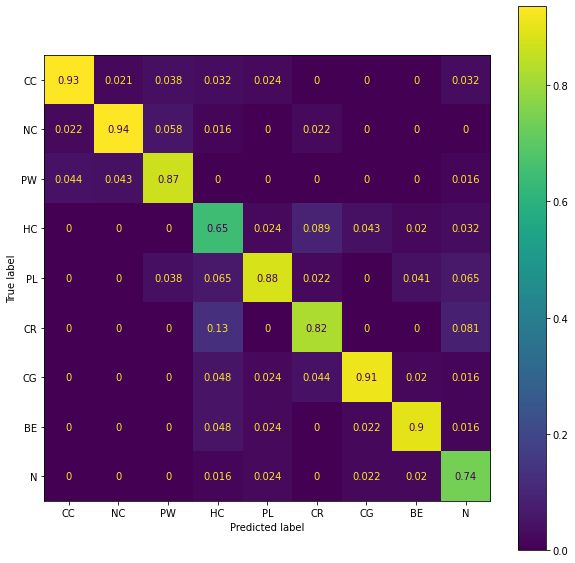

In [14]:
# plot confusion matrix
cm = confusion_matrix(test_labels, y_pred , normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)